# Lockdown 2020-12-25

In [19]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

In [20]:
#data found:
#https://github.com/ccodwg/CovidTimelineCanada/tree/main/data/pt


df = pd.read_csv('/Users/jamiekanagasundram/Documents/concordia-bootcamps/Git_hub folder/Project 2 -RRD/cases_pt.csv')
df = df.loc[df['region']=='QC']  #only looking at QC


#change date to only look at our interval
df['date'] = pd.to_datetime(df['date'])

start_date = '2020-11-24'
end_date = '2021-01-25'

period = (df['date']>start_date) &(df['date']<=end_date)
df = df.loc[period]

df


,name,region,date,value,value_daily
10435,cases,QC,2020-11-25,128195,1275
10436,cases,QC,2020-11-26,129624,1429
10437,cases,QC,2020-11-27,130996,1372
10438,cases,QC,2020-11-28,132410,1414
10439,cases,QC,2020-11-29,133678,1268
...,...,...,...,...,...
10492,cases,QC,2021-01-21,241245,1612
10493,cases,QC,2021-01-22,242916,1671
10494,cases,QC,2021-01-23,244416,1500
10495,cases,QC,2021-01-24,245806,1390


In [21]:
#number each data point 30 days before and after the threshold
cutoff = datetime.strptime('2020-12-25',"%Y-%m-%d")
df['diff'] = df['date']-cutoff
df['diff']= df['diff'].astype('timedelta64[D]')
df

,name,region,date,value,value_daily,diff
10435,cases,QC,2020-11-25,128195,1275,-30.0
10436,cases,QC,2020-11-26,129624,1429,-29.0
10437,cases,QC,2020-11-27,130996,1372,-28.0
10438,cases,QC,2020-11-28,132410,1414,-27.0
10439,cases,QC,2020-11-29,133678,1268,-26.0
...,...,...,...,...,...,...
10492,cases,QC,2021-01-21,241245,1612,27.0
10493,cases,QC,2021-01-22,242916,1671,28.0
10494,cases,QC,2021-01-23,244416,1500,29.0
10495,cases,QC,2021-01-24,245806,1390,30.0


In [22]:
#create a new column to assing 0 and 1 to create the two graphs to see before and after lockdown
df['threshold'] = None


#value 0 assigned to data before the threshold and values 1 assinged to values = to or above the threshold
pre_lockdown = df['diff'] < 0
post_lockdown = df['diff'] >= 0
df.loc[pre_lockdown, 'threshold'] = 0
df.loc[post_lockdown, 'threshold'] = 1
df


#if the lockdowns are working then the number of deaths should be going down
df.sample(10)

,name,region,date,value,value_daily,diff,threshold
10479,cases,QC,2021-01-08,216762,2799,14.0,1
10440,cases,QC,2020-11-30,134923,1245,-25.0,0
10458,cases,QC,2020-12-18,166512,2192,-7.0,0
10444,cases,QC,2020-12-04,141234,1711,-21.0,0
10475,cases,QC,2021-01-04,206168,2340,10.0,1
10447,cases,QC,2020-12-07,146028,1499,-18.0,0
10464,cases,QC,2020-12-24,179282,2374,-1.0,0
10484,cases,QC,2021-01-13,227513,2165,19.0,1
10476,cases,QC,2021-01-05,208678,2510,11.0,1
10456,cases,QC,2020-12-16,162195,1865,-9.0,0


In [23]:
#before lockdown
pre_lock = df[df['threshold']==0]
X_pre = np.array(pre_lock['diff']*-1)
X1_pre = sm.add_constant(X_pre)
y_pre = pre_lock['value_daily']
pre_lock = sm.WLS(y_pre, X1_pre).fit()
pre = pre_lock.fittedvalues
print(pre_lock.summary())

                            WLS Regression Results                            
Dep. Variable:            value_daily   R-squared:                       0.863
Model:                            WLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     177.0
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           1.26e-13
Time:                        19:01:11   Log-Likelihood:                -184.46
No. Observations:                  30   AIC:                             372.9
Df Residuals:                      28   BIC:                             375.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2255.3724     43.899     51.376      0.0

In [24]:
#after lockdown
post_lock = df[df['threshold']==1]
X_post = np.array(post_lock['diff'])
X1_post = sm.add_constant(X_post)
y_post = post_lock['value_daily']
post_lock = sm.WLS(y_post, X1_post).fit()
post = post_lock.fittedvalues
post = post_lock.fittedvalues
print(post_lock.summary())

                            WLS Regression Results                            
Dep. Variable:            value_daily   R-squared:                       0.597
Model:                            WLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     44.37
Date:                Thu, 12 Jan 2023   Prob (F-statistic):           2.23e-07
Time:                        19:01:12   Log-Likelihood:                -228.87
No. Observations:                  32   AIC:                             461.7
Df Residuals:                      30   BIC:                             464.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2745.5568    110.234     24.907      0.0

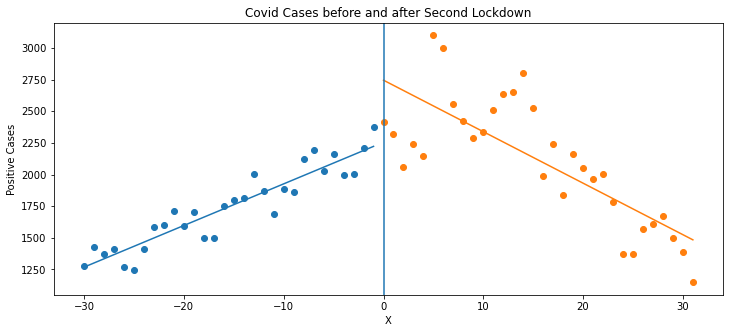

In [25]:
fig, ax = plt.subplots(figsize=(12,5))

#left side
ax.scatter(X1_pre[:,1]*-1, y_pre)
ax.plot(X1_pre[:,1]*-1, pre)
#right side 
ax.scatter(X1_post[:,1], y_post)
ax.plot(X1_post[:,1], post)


ax.set_title('Covid Cases before and after Second Lockdown')
ax.set_ylabel('Positive Cases')
ax.set_xlabel('X')
ax.axvline()
plt.show()

The parameter chosen as the cut off point is the date of the second lockdown 25/12/2020. In our summary tables the p-value is displays 0.000, which is statitically significant because its bellow 0.05, meaning the null hypothesis can be rejected. Our null hypothesis here would be that a second lockdown would not have an effect on the number of covid cases.

In both cases pre and post lockdown, the coefficients are negative, suggesting that as the predictor variable increases, the response variable decreases. In our case the response varibale is the number of cases. 


In conclusion, we can see that he 20/3/2020 lockdown, the reopening of schools on 31/8/2020, and the 25/12/2020 lockdown all had an effect on the number of Covid cases in Quebec. Starting with the 20/3/2020 lockdown, it's clear that there was still a steady increase in the number of cases, however this increase could have been much more severe if the lockdown was not put in place. 

This is shown in the next example with the reopening of schools. We can see a significant increase in the rate at which covid cases increased per day after the schools reopened. This leads us to conclude that not only did the reopening of schools had a significant stastitical increase on the number of covid cases, but that the 20/3/2020 lockdown possibly decreased the number of cases. We reach this conclusion by seeing how drastically the reopening had an impact, so we can assume that the lockdown had an inverse effect, at least to a certain degree. 

Again we see an increase in cases leading up the the 2nd lockdown, and once the second lockdown was in place the cases start to decrease once more. 
